In [2]:
import argparse
import os
import random
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from scipy import sparse
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# argparse 설정
parser = argparse.ArgumentParser()
parser.add_argument("--data_dir", default="train.parquet", type=str)
parser.add_argument("--dir_path", default="./data/", type=str)

args, unknown = parser.parse_known_args()

In [4]:
train_df = pd.read_parquet(os.path.join(args.dir_path, args.data_dir))
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [5]:
sample_submission.head()

,user_id,item_id
0,0000162d-72b9-4b0f-8895-7b52b6661c82,59e492d8-994e-4328-8a8d-4f51d3cc23f3
1,0000162d-72b9-4b0f-8895-7b52b6661c82,3f2eebd4-b070-4140-8618-63839c4f9524
2,0000162d-72b9-4b0f-8895-7b52b6661c82,586c4927-df6e-4ee3-a02b-c877f8ea1159
3,0000162d-72b9-4b0f-8895-7b52b6661c82,0833ccaa-0a09-4619-b477-4a4f74a22253
4,0000162d-72b9-4b0f-8895-7b52b6661c82,235dac51-966d-4497-85e1-1b0173d76ed0


In [6]:
# user_id의 고유한 개수 계산
unique_users = train_df['user_id'].nunique()

# item_id의 고유한 개수 계산
unique_items = train_df['item_id'].nunique()

print(f"고유한 user_id의 개수: {unique_users}")
print(f"고유한 item_id의 개수: {unique_items}")

# 추가로 전체 데이터의 행 수도 표시
total_rows = len(train_df)
print(f"전체 데이터의 행 수: {total_rows}")

# 데이터프레임의 기본 정보 출력
print("\n데이터프레임 정보:")
train_df.info()

# 처음 몇 개의 행 출력
print("\n데이터프레임의 처음 5개 행:")
print(train_df.head())

고유한 user_id의 개수: 638257
고유한 item_id의 개수: 29502
전체 데이터의 행 수: 8350311

데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 8350311 entries, 0 to 8350310
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   item_id        object 
 2   user_session   object 
 3   event_time     object 
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   event_type     object 
dtypes: float64(1), object(7)
memory usage: 573.4+ MB

데이터프레임의 처음 5개 행:
                                user_id                               item_id  \
0  0b517454-e7c3-44ec-8c39-a68ef9c0ec60  18c11cbb-a18d-4a9e-bdea-6abd3f7d3c04   
1  215eeee5-f9c5-4213-8641-7561dbdad1b9  47c5a6da-32d0-4a29-8b51-57304f476ded   
2  a25bf14a-49ac-49bb-87de-ee6b300f0cc4  a6d915c6-2bb7-4393-a556-c327723d3666   
3  09ee8591-25e0-4bb4-ae24-c48ed4212e3c  0fd4da5d-989c-4a75-9ace-2b108f834c8c   
4  7acf7c81-69f6-4aa8-b19f-8e85aeaffc28  d52d1c91-5534-4

In [7]:
# 원본 데이터 백업
original_category_code = train_df['category_code'].copy()

# 'apparel.' 접두사 제거
train_df['category_code'] = train_df['category_code'].str.replace('^apparel\.', '', regex=True)

# 변경된 행의 수 계산
changed_rows = (original_category_code != train_df['category_code']).sum()

# 전체 행의 수
total_rows = len(train_df)

print(f"총 {total_rows}개의 행 중 {changed_rows}개의 행에서 'apparel.' 접두사가 제거되었습니다.")
print(f"변경된 비율: {changed_rows/total_rows:.2%}")

# 변경 전후 처음 5개 행 출력
print("\n변경 전 처음 5개 행의 category_code:")
print(original_category_code.head())

print("\n변경 후 처음 5개 행의 category_code:")
print(train_df['category_code'].head())

총 8350311개의 행 중 8350311개의 행에서 'apparel.' 접두사가 제거되었습니다.
변경된 비율: 100.00%

변경 전 처음 5개 행의 category_code:
0     apparel.shoes
1     apparel.shoes
2    apparel.tshirt
3     apparel.shoes
4     apparel.shoes
Name: category_code, dtype: object

변경 후 처음 5개 행의 category_code:
0     shoes
1     shoes
2    tshirt
3     shoes
4     shoes
Name: category_code, dtype: object


In [8]:
train_df.head()

,user_id,item_id,user_session,event_time,category_code,brand,price,event_type
0,0b517454-e7c3-44ec-8c39-a68ef9c0ec60,18c11cbb-a18d-4a9e-bdea-6abd3f7d3c04,ad97f19a-f5fb-41ea-a7b2-52c21fb37ab2,2019-11-16 16:31:26 UTC,shoes,kapika,72.05,view
1,215eeee5-f9c5-4213-8641-7561dbdad1b9,47c5a6da-32d0-4a29-8b51-57304f476ded,6058b45b-bdb9-4d6c-b300-42dcb1cb8280,2019-11-04 18:59:50 UTC,shoes,respect,82.63,view
2,a25bf14a-49ac-49bb-87de-ee6b300f0cc4,a6d915c6-2bb7-4393-a556-c327723d3666,28a8b8e3-b374-435d-9d5d-b96058ecb75b,2019-11-26 09:01:47 UTC,tshirt,goodloot,24.43,view
3,09ee8591-25e0-4bb4-ae24-c48ed4212e3c,0fd4da5d-989c-4a75-9ace-2b108f834c8c,f2972db7-9916-4a58-b6f9-c76afde6245e,2019-11-15 16:05:34 UTC,shoes,baden,70.79,view
4,7acf7c81-69f6-4aa8-b19f-8e85aeaffc28,d52d1c91-5534-4de4-aaf1-318e932e10e7,7d46d970-b40e-4a2f-81a7-65bf23aa0aae,2019-11-16 13:14:09 UTC,shoes,rooman,53.80,view


In [9]:
# event_time을 datetime 형식으로 변환
train_df['event_time'] = pd.to_datetime(train_df['event_time'])

# 각 user_id별로 가장 많이 본 category_code를 찾아 favorite 컬럼으로 추가
favorite_category = train_df.groupby('user_id')['category_code'].agg(lambda x: x.value_counts().index[0]).reset_index()
favorite_category.columns = ['user_id', 'favorite']
train_pre = train_df.merge(favorite_category, on='user_id', how='left')

In [12]:
unique_users = train_pre['user_id'].nunique()
print(f"고유한 user_id의 개수: {unique_users}")
train_pre.head()

고유한 user_id의 개수: 638257


,user_id,item_id,user_session,event_time,category_code,brand,price,event_type,favorite
0,0b517454-e7c3-44ec-8c39-a68ef9c0ec60,18c11cbb-a18d-4a9e-bdea-6abd3f7d3c04,ad97f19a-f5fb-41ea-a7b2-52c21fb37ab2,2019-11-16 16:31:26+00:00,shoes,kapika,72.05,view,shoes
1,215eeee5-f9c5-4213-8641-7561dbdad1b9,47c5a6da-32d0-4a29-8b51-57304f476ded,6058b45b-bdb9-4d6c-b300-42dcb1cb8280,2019-11-04 18:59:50+00:00,shoes,respect,82.63,view,shoes
2,a25bf14a-49ac-49bb-87de-ee6b300f0cc4,a6d915c6-2bb7-4393-a556-c327723d3666,28a8b8e3-b374-435d-9d5d-b96058ecb75b,2019-11-26 09:01:47+00:00,tshirt,goodloot,24.43,view,underwear
3,09ee8591-25e0-4bb4-ae24-c48ed4212e3c,0fd4da5d-989c-4a75-9ace-2b108f834c8c,f2972db7-9916-4a58-b6f9-c76afde6245e,2019-11-15 16:05:34+00:00,shoes,baden,70.79,view,shoes
4,7acf7c81-69f6-4aa8-b19f-8e85aeaffc28,d52d1c91-5534-4de4-aaf1-318e932e10e7,7d46d970-b40e-4a2f-81a7-65bf23aa0aae,2019-11-16 13:14:09+00:00,shoes,rooman,53.80,view,shoes


In [13]:
# 각 사용자별로 이벤트 타입 확인
user_event_types = train_pre.groupby('user_id')['event_type'].unique()
print("\n사용자별 이벤트 타입:")
print(user_event_types)

# view만 있는 사용자 찾기
view_only_users = user_event_types[user_event_types.apply(lambda x: set(x) == {'view'})].index

print("\nview만 있는 사용자:")
print(view_only_users)

# view만 있는 사용자의 마지막 view 데이터 선택
last_views = train_pre[train_pre['user_id'].isin(view_only_users)].groupby('user_id').apply(lambda x: x.loc[x['event_time'].idxmax()])

# 다른 이벤트 타입을 가진 사용자의 모든 데이터 선택
other_events = train_pre[~train_pre['user_id'].isin(view_only_users)]

# 결과 데이터프레임 생성
result_df = pd.concat([last_views, other_events]).sort_values('user_id').reset_index(drop=True)

print("\n최종 결과:")
print(result_df)

print("\n남은 레코드 수:", len(result_df))
print("\n이벤트 타입 분포:")
print(result_df['event_type'].value_counts())

print("\n사용자별 남은 레코드 수:")
print(result_df['user_id'].value_counts().sort_index())


사용자별 이벤트 타입:
user_id
0000162d-72b9-4b0f-8895-7b52b6661c82    [view]
00001710-fd5d-47e4-aecb-8da4173a7c02    [view]
00002da8-29b8-4d15-bf99-b4b4475e4631    [view]
00002dee-c493-4ad7-b7e1-093f572b0e75    [view]
0000334c-aad3-4036-a746-b05a4a5896a7    [view]
                                         ...  
ffff60a4-eed8-439b-9741-6d5e57214199    [view]
ffff7f5c-25ea-4844-a1f8-dcadc9d4a105    [view]
ffffa0d0-d3fe-4098-a8fb-f8dccff0709d    [view]
ffffc371-aee8-4d93-9327-fdb777037789    [view]
ffffc959-2575-476c-b897-057e51182c5f    [view]
Name: event_type, Length: 638257, dtype: object

view만 있는 사용자:
Index(['0000162d-72b9-4b0f-8895-7b52b6661c82',
       '00001710-fd5d-47e4-aecb-8da4173a7c02',
       '00002da8-29b8-4d15-bf99-b4b4475e4631',
       '00002dee-c493-4ad7-b7e1-093f572b0e75',
       '0000334c-aad3-4036-a746-b05a4a5896a7',
       '0000475b-31db-4544-9cc4-6594dd027a58',
       '0000643c-232c-43c4-ab4a-0943e0a2a226',
       '00006e48-a49f-4264-8439-13d1bd0fe8c0',
       '0000768c-463a-

In [20]:
unique_users = result_df['user_id'].nunique()
print(f"고유한 user_id의 개수: {unique_users}")
result_df.head()

고유한 user_id의 개수: 638257


,user_id,item_id,user_session,event_time,category_code,brand,price,event_type,favorite
0,0000162d-72b9-4b0f-8895-7b52b6661c82,0bb05529-df13-46ca-8bfc-832344a7b1d3,e997c2dd-793e-41e2-ad13-ac96cee1b662,2019-12-28 06:54:33+00:00,shoes.slipons,apple,643.23,view,shoes.slipons
1,00001710-fd5d-47e4-aecb-8da4173a7c02,838f5917-138a-4e84-8e98-e75b5622c9b6,4d61c08a-10f3-4b9d-adb6-1f5af9ef6e2b,2020-01-01 12:56:27+00:00,jumper,machete,38.61,view,jumper
2,00002da8-29b8-4d15-bf99-b4b4475e4631,2e0d2baf-84f8-4609-8411-40106770595a,0b7330af-3f9c-4c19-9763-7d524b7a2749,2020-02-15 17:55:28+00:00,shoes,xiaomi,33.15,view,shoes
3,00002dee-c493-4ad7-b7e1-093f572b0e75,f8d2e7b6-6a09-404e-b1ca-1db09ba7ce7e,91176fcc-7724-460c-8cb9-60443995ff72,2020-02-24 10:55:09+00:00,shoes.keds,rieker,46.59,view,shoes.keds
4,0000334c-aad3-4036-a746-b05a4a5896a7,ee0bfdd8-3856-425b-8714-d07370b672d2,d1d5d026-fd89-4907-b036-af99496b232f,2019-11-07 04:15:51+00:00,shoes.keds,reebok,118.15,view,shoes.keds


In [21]:
result_df['event_time'] = result_df['event_time'].astype(str)

# CSV 파일로 저장
result_df.to_csv('./data/train_pre.csv')

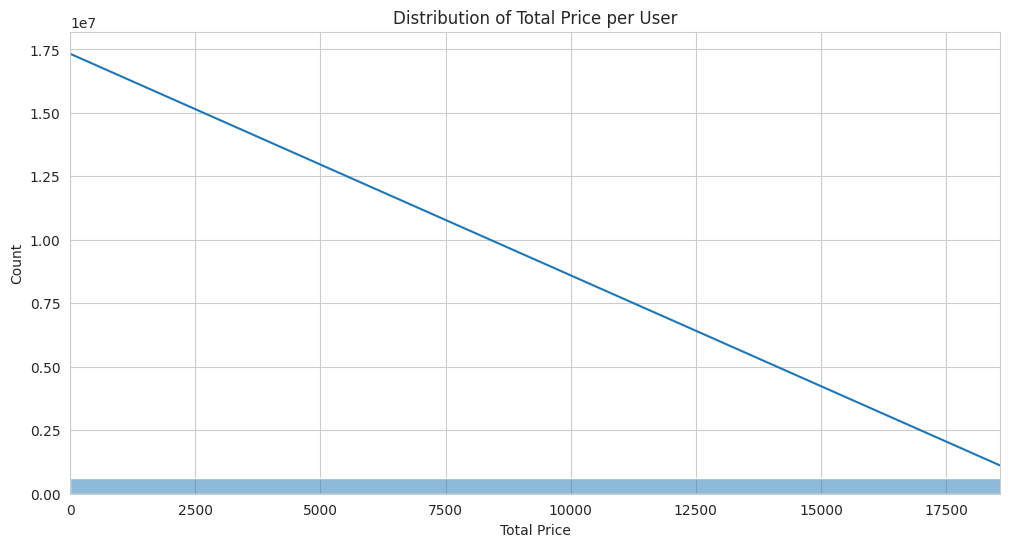

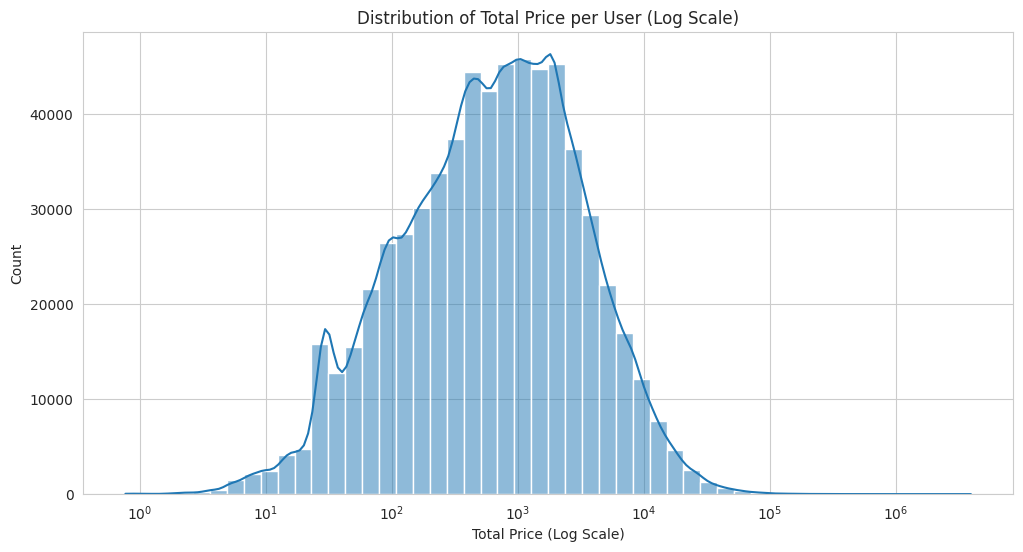

count    6.382570e+05
mean     1.974432e+03
std      8.032530e+03
min      7.700000e-01
25%      1.894500e+02
50%      6.692300e+02
75%      1.965550e+03
max      3.939803e+06
Name: price, dtype: float64

Top 10 Users by Total Price:
                                     user_id       price
240457  6034a8f4-0f6a-4af4-8e8c-7fff6649058b  3939802.58
137206  36da5b84-f57a-413b-8a4d-f8b58a4072c7  2128725.34
167067  42d49830-b319-42bc-b26e-6d5bc7398600  1135033.00
150779  3c5a0af3-e14a-48fa-b969-07ecdeb1ab77  1109364.46
351872  8d18164d-c73d-4585-9bee-ed694f92d5a4   872838.68
421986  a95ea7d8-d230-4e96-b207-1de9240a38ee   744246.47
226125  5a75c29e-80b4-4cff-b6e4-c2e249ff1db5   740661.68
565477  e2c0a268-41f4-4164-a154-b6447e39a144   734555.00
279145  6fbda0d4-fe5b-47b7-93c5-3a114e2d54d0   710620.96
473699  bdea8658-28a5-483a-a931-7bad962a9932   706698.15


In [8]:
# user_id별 price 합계 계산
user_price_sum = train_df.groupby('user_id')['price'].sum().reset_index()

# seaborn 스타일 설정
sns.set_style("whitegrid")

# 첫 번째 그래프: 일반 스케일 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(data=user_price_sum, x='price', kde=True, bins=50)
plt.title('Distribution of Total Price per User')
plt.xlabel('Total Price')
plt.ylabel('Count')

# x축 범위 조정 (극단값 제외)
plt.xlim(0, np.percentile(user_price_sum['price'], 99))

plt.show()

# 두 번째 그래프: 로그 스케일 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(data=user_price_sum, x='price', kde=True, bins=50, log_scale=True)
plt.title('Distribution of Total Price per User (Log Scale)')
plt.xlabel('Total Price (Log Scale)')
plt.ylabel('Count')

plt.show()

# 기본 통계량 출력
print(user_price_sum['price'].describe())

# 상위 10명의 사용자 출력
print("\nTop 10 Users by Total Price:")
print(user_price_sum.nlargest(10, 'price'))

In [9]:
# 구매 이벤트 식별 (event_type이 'purchase'인 경우)
purchases = train_df[train_df['event_type'] == 'purchase']

# 사용자별 구매 횟수 계산
user_purchase_count = purchases.groupby('user_id').size().reset_index(name='purchase_count')

# 전체 고유 사용자 수 계산
total_users = train_df['user_id'].nunique()

# 구매한 적 있는 사용자 수 계산
users_with_purchases = user_purchase_count['user_id'].nunique()

# 한 번도 구매하지 않은 사용자 수 계산
users_without_purchases = total_users - users_with_purchases

print(f"한 번도 구매하지 않은 사용자 수: {users_without_purchases}")

# 구매를 가장 많이 한 10명의 구매 횟수 출력
top_10_purchasers = user_purchase_count.nlargest(10, 'purchase_count')
print("\n구매를 가장 많이 한 10명의 구매 횟수:")
print(top_10_purchasers)

# 전체 통계 요약
print("\n전체 통계:")
print(f"전체 고유 사용자 수: {total_users}")
print(f"구매한 적 있는 사용자 수: {users_with_purchases}")
print(f"구매 비율: {users_with_purchases/total_users:.2%}")

한 번도 구매하지 않은 사용자 수: 636576

구매를 가장 많이 한 10명의 구매 횟수:
                                   user_id  purchase_count
1605  f3f1f11e-7d61-47b9-a3f2-5320873a2b4d              11
245   276be7ef-5b6d-4527-be81-980ab3dfb21e               9
512   4fc26eb7-19da-4835-bae5-67117076b480               9
1190  b6925cb4-fce6-4d5c-b6b3-d4a28bd05a1f               9
1538  ea9ae056-fc1f-405f-b25a-3b038acbec7c               8
1633  f71d96d4-6d63-4da0-b3e1-625b5b5f70ec               8
229   250df756-bf81-4b55-97e5-d01c1bb2490a               7
1069  a3baa73e-a69f-47b5-a0a2-f960c1cd8aa6               6
410   403cdc20-cb90-411e-800b-ed892cbd9563               5
467   4992917d-9474-48f4-89ef-e6606f878659               5

전체 통계:
전체 고유 사용자 수: 638257
구매한 적 있는 사용자 수: 1681
구매 비율: 0.26%


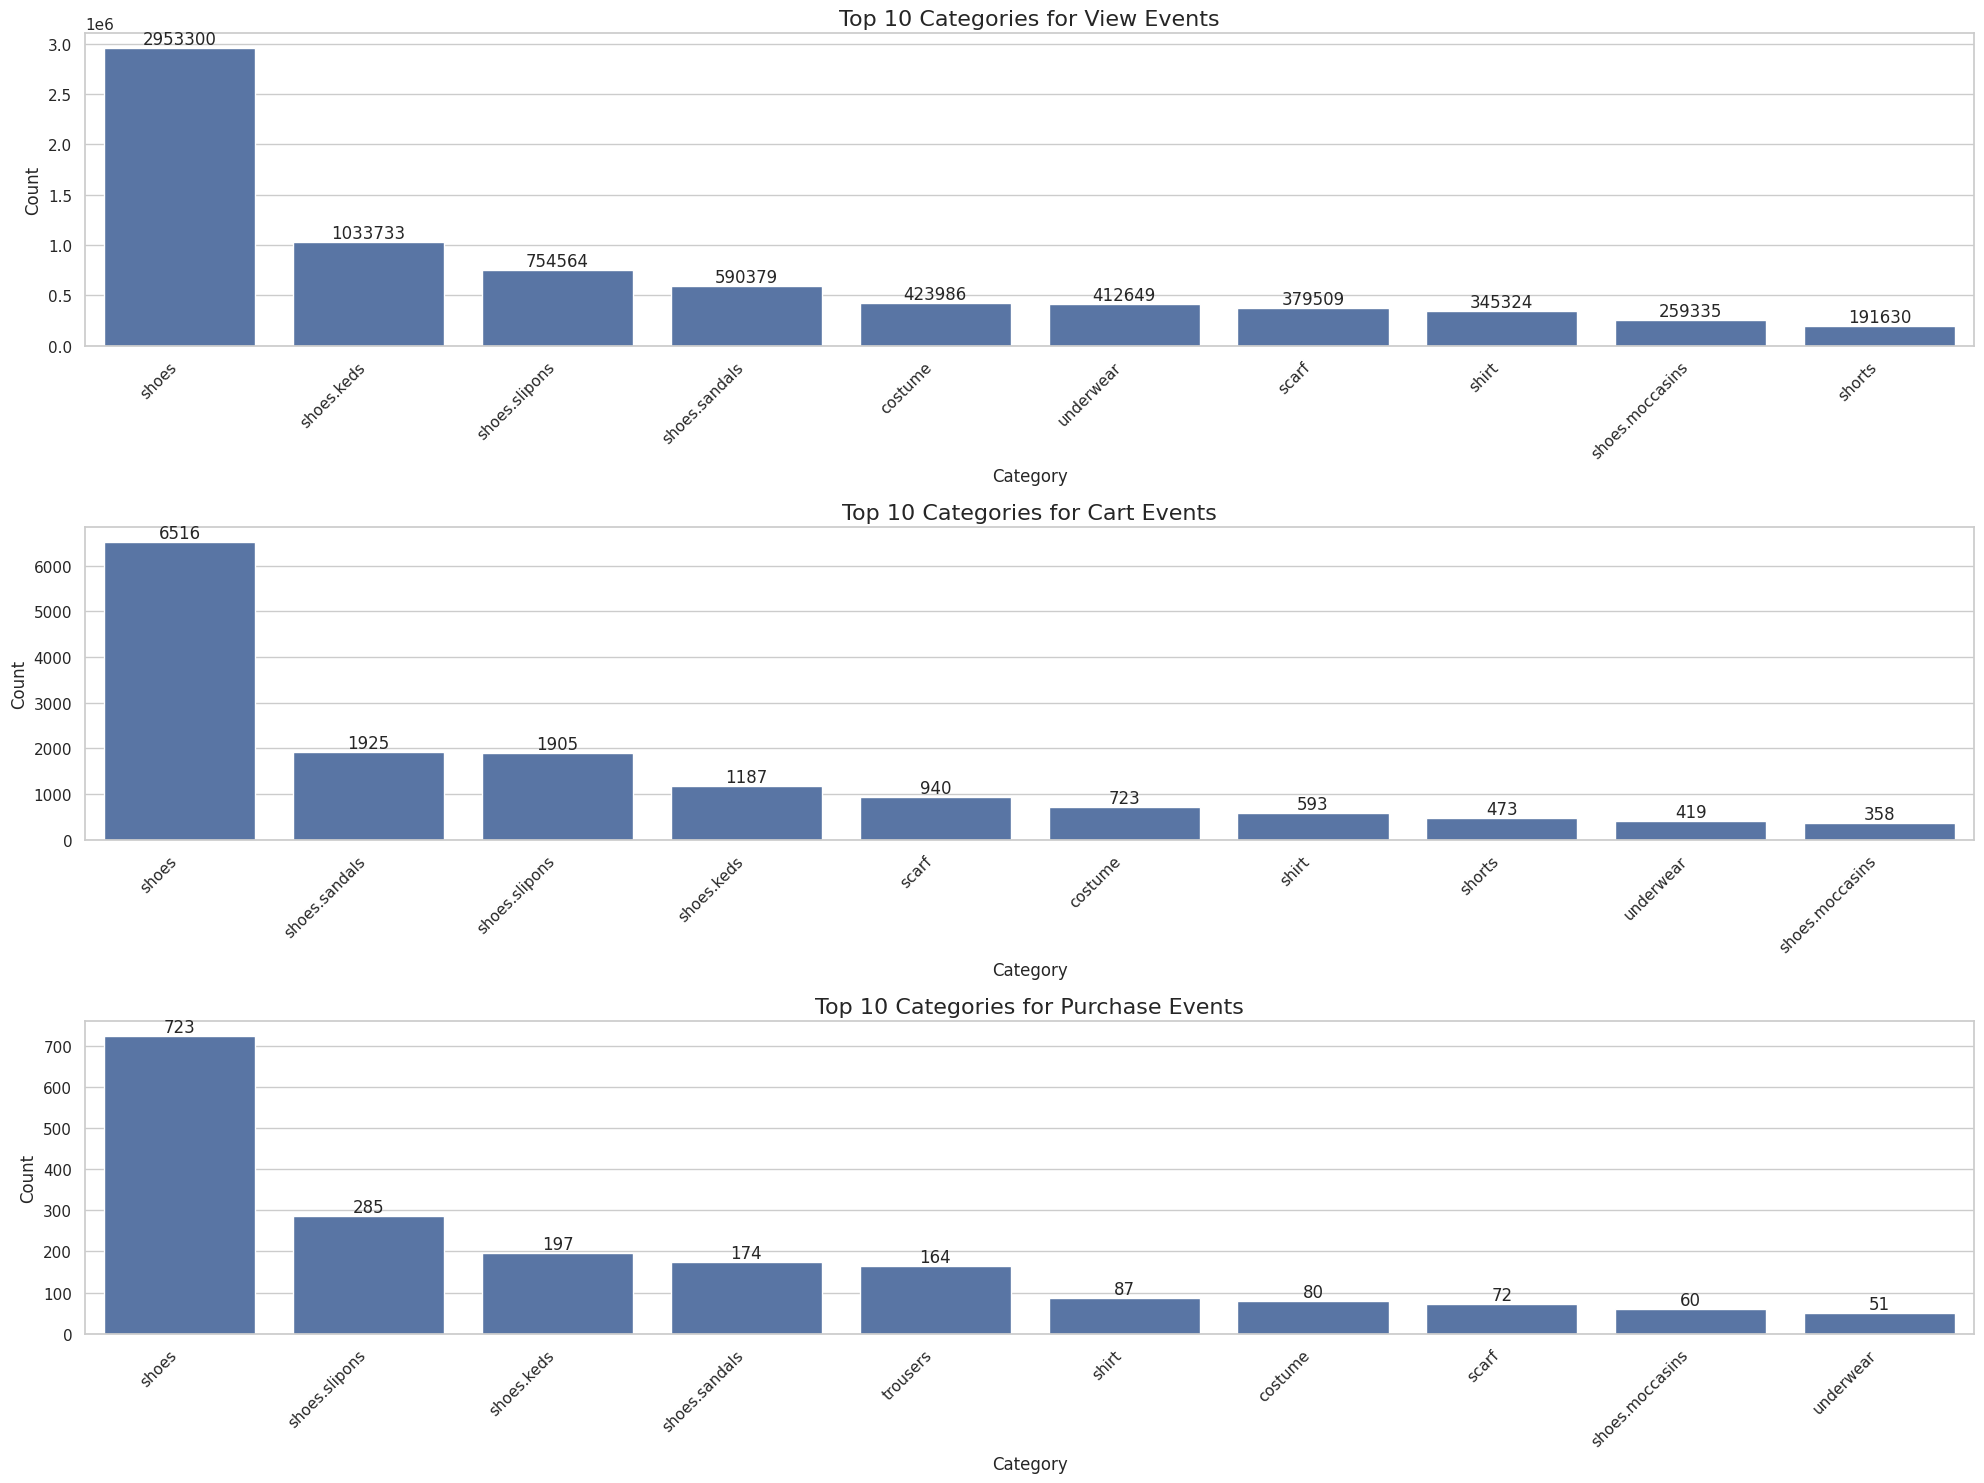

각 이벤트 타입별 상위 5개 카테고리:

View 이벤트:
category_code
shoes            2953300
shoes.keds       1033733
shoes.slipons     754564
shoes.sandals     590379
costume           423986
Name: count, dtype: int64

Cart 이벤트:
category_code
shoes            6516
shoes.sandals    1925
shoes.slipons    1905
shoes.keds       1187
scarf             940
Name: count, dtype: int64

Purchase 이벤트:
category_code
shoes            723
shoes.slipons    285
shoes.keds       197
shoes.sandals    174
trousers         164
Name: count, dtype: int64


In [10]:
# 이벤트 타입 리스트
event_types = ['view', 'cart', 'purchase']

# 그래프 설정
plt.figure(figsize=(20, 15))
sns.set(style="whitegrid")

# 각 이벤트 타입별로 그래프 생성
for i, event in enumerate(event_types, 1):
    # 해당 이벤트 타입의 데이터만 필터링
    event_data = train_df[train_df['event_type'] == event]
    
    # 카테고리별 count 계산
    category_counts = event_data['category_code'].value_counts().nlargest(10)
    
    # 서브플롯 생성
    plt.subplot(3, 1, i)
    
    # 막대 그래프 그리기
    sns.barplot(x=category_counts.index, y=category_counts.values)
    
    # 그래프 제목과 레이블 설정
    plt.title(f'Top 10 Categories for {event.capitalize()} Events', fontsize=16)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # x축 레이블 회전
    plt.xticks(rotation=45, ha='right')
    
    # 막대 위에 값 표시
    for j, v in enumerate(category_counts.values):
        plt.text(j, v, str(v), ha='center', va='bottom')

# 그래프 간 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

# 각 이벤트 타입별 상위 5개 카테고리 출력
print("각 이벤트 타입별 상위 5개 카테고리:")
for event in event_types:
    event_data = train_df[train_df['event_type'] == event]
    top_categories = event_data['category_code'].value_counts().nlargest(5)
    print(f"\n{event.capitalize()} 이벤트:")
    print(top_categories)

In [9]:
# user_id의 고유한 개수 계산
unique_users = sample_submission['user_id'].nunique()

# item_id의 고유한 개수 계산
unique_items = sample_submission['item_id'].nunique()

print(f"고유한 user_id의 개수: {unique_users}")
print(f"고유한 item_id의 개수: {unique_items}")

# 추가로 전체 데이터의 행 수도 표시
total_rows = len(sample_submission)
print(f"전체 데이터의 행 수: {total_rows}")

# 데이터프레임의 기본 정보 출력
print("\n데이터프레임 정보:")
sample_submission.info()

# 처음 몇 개의 행 출력
print("\n데이터프레임의 처음 5개 행:")
print(sample_submission.head())

고유한 user_id의 개수: 638257
고유한 item_id의 개수: 29502
전체 데이터의 행 수: 6382570

데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6382570 entries, 0 to 6382569
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   item_id  object
dtypes: object(2)
memory usage: 97.4+ MB

데이터프레임의 처음 5개 행:
                                user_id                               item_id
0  0000162d-72b9-4b0f-8895-7b52b6661c82  59e492d8-994e-4328-8a8d-4f51d3cc23f3
1  0000162d-72b9-4b0f-8895-7b52b6661c82  3f2eebd4-b070-4140-8618-63839c4f9524
2  0000162d-72b9-4b0f-8895-7b52b6661c82  586c4927-df6e-4ee3-a02b-c877f8ea1159
3  0000162d-72b9-4b0f-8895-7b52b6661c82  0833ccaa-0a09-4619-b477-4a4f74a22253
4  0000162d-72b9-4b0f-8895-7b52b6661c82  235dac51-966d-4497-85e1-1b0173d76ed0


In [10]:
# train_df와 sample_submission의 고유한 user_id와 item_id 추출
train_users = set(train_df['user_id'].unique())
train_items = set(train_df['item_id'].unique())
submission_users = set(sample_submission['user_id'].unique())
submission_items = set(sample_submission['item_id'].unique())

# user_id 비교
users_only_in_train = train_users - submission_users
users_only_in_submission = submission_users - train_users

# item_id 비교
items_only_in_train = train_items - submission_items
items_only_in_submission = submission_items - train_items

print(f"Train 데이터셋의 고유한 user_id 수: {len(train_users)}")
print(f"Submission 데이터셋의 고유한 user_id 수: {len(submission_users)}")
print(f"Train에만 있는 user_id 수: {len(users_only_in_train)}")
print(f"Submission에만 있는 user_id 수: {len(users_only_in_submission)}")
print("\n")
print(f"Train 데이터셋의 고유한 item_id 수: {len(train_items)}")
print(f"Submission 데이터셋의 고유한 item_id 수: {len(submission_items)}")
print(f"Train에만 있는 item_id 수: {len(items_only_in_train)}")
print(f"Submission에만 있는 item_id 수: {len(items_only_in_submission)}")

Train 데이터셋의 고유한 user_id 수: 638257
Submission 데이터셋의 고유한 user_id 수: 638257
Train에만 있는 user_id 수: 0
Submission에만 있는 user_id 수: 0


Train 데이터셋의 고유한 item_id 수: 29502
Submission 데이터셋의 고유한 item_id 수: 29502
Train에만 있는 item_id 수: 0
Submission에만 있는 item_id 수: 0

Train에만 있는 user_id 샘플 (최대 5개):
[]

Submission에만 있는 user_id 샘플 (최대 5개):
[]

Train에만 있는 item_id 샘플 (최대 5개):
[]

Submission에만 있는 item_id 샘플 (최대 5개):
[]


In [5]:
# event_type 컬럼의 고유한 값들 추출 및 출력
unique_event_types = train_df['event_type'].unique()

print("Unique values in event_type column:")
for event_type in unique_event_types:
    print(f"- {event_type}")

# 각 이벤트 타입의 개수와 비율 계산
event_type_counts = train_df['event_type'].value_counts()
event_type_percentages = train_df['event_type'].value_counts(normalize=True) * 100

print("\nEvent type distribution:")
for event_type, count in event_type_counts.items():
    percentage = event_type_percentages[event_type]
    print(f"{event_type}: {count} ({percentage:.2f}%)")

Unique values in event_type column:
- view
- purchase
- cart

Event type distribution:
view: 8331873 (99.78%)
cart: 16362 (0.20%)
purchase: 2076 (0.02%)


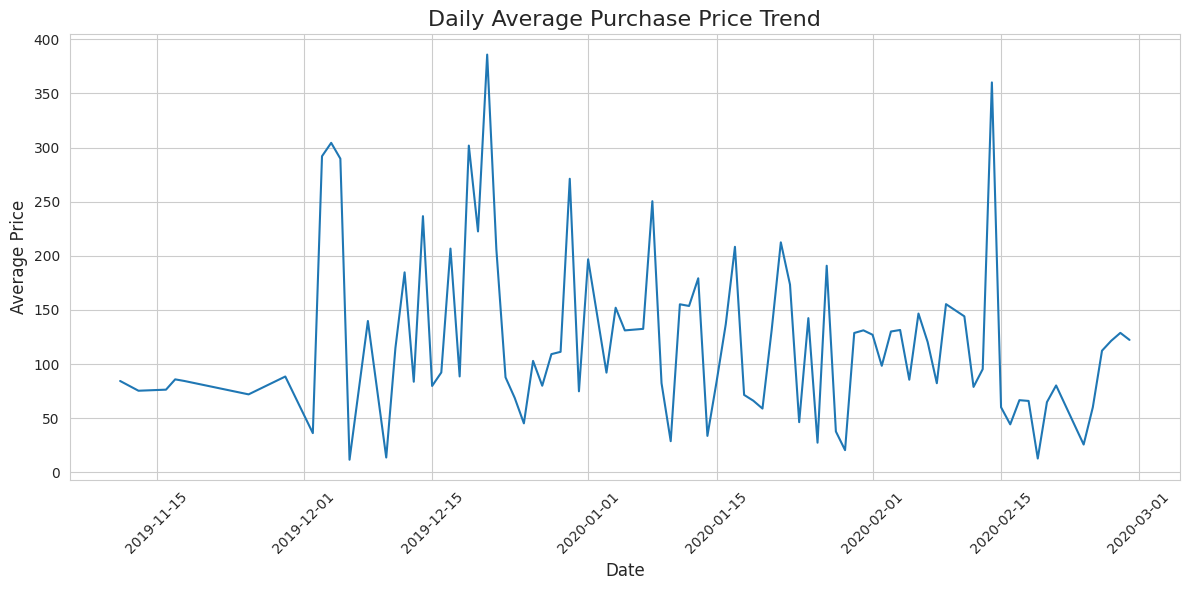

/tmp/ipykernel_920215/2218900664.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_avg_price = purchases.groupby(purchases['event_time'].dt.to_period('M'))['price'].mean().reset_index()


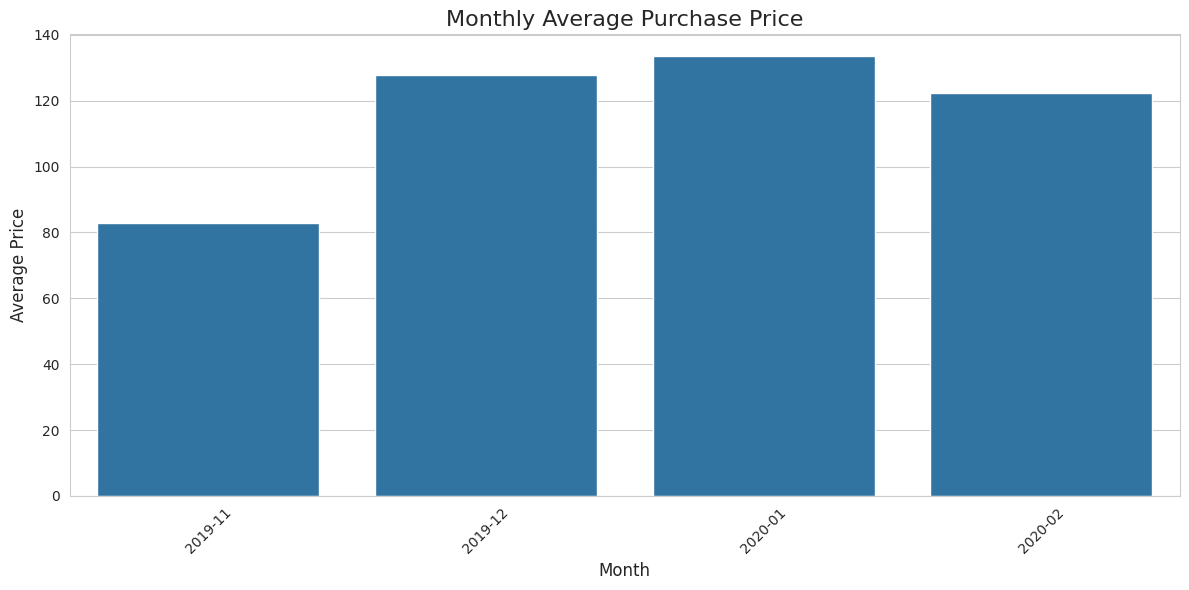

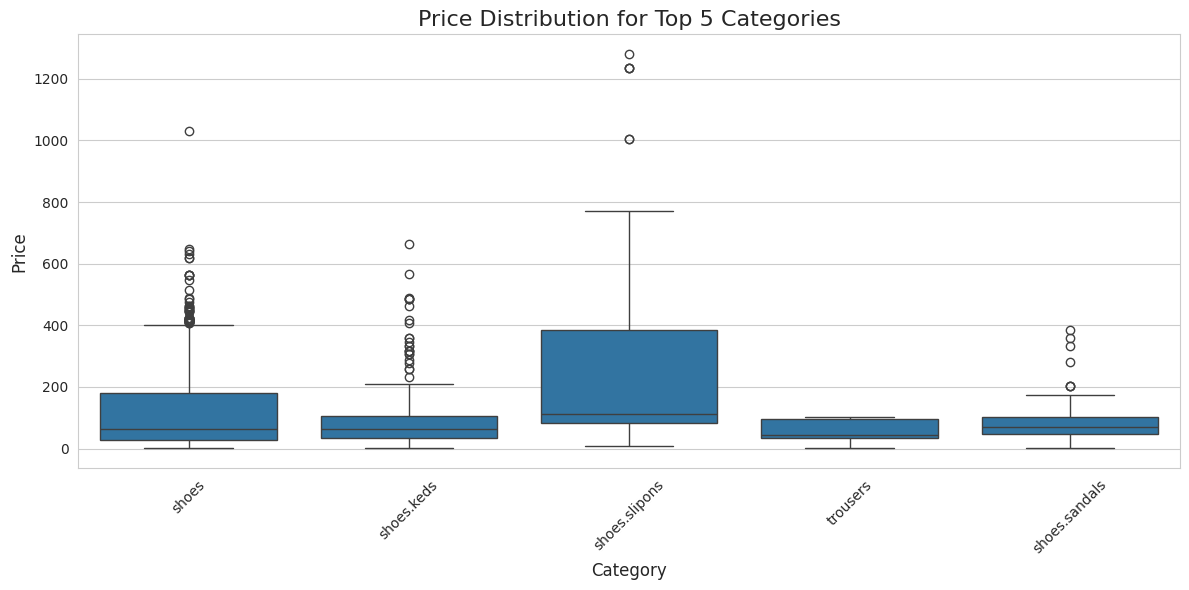

In [9]:
# event_time을 datetime으로 변환
train_df['event_time'] = pd.to_datetime(train_df['event_time'])

# 구매 데이터만 필터링
purchases = train_df[train_df['event_type'] == 'purchase']

# 날짜별 평균 구매 가격 계산
daily_avg_price = purchases.groupby(purchases['event_time'].dt.date)['price'].mean().reset_index()

# 그래프 스타일 설정
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# 선 그래프 그리기
sns.lineplot(x='event_time', y='price', data=daily_avg_price)

# 그래프 제목과 레이블 설정
plt.title('Daily Average Purchase Price Trend', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Price', fontsize=12)

# x축 레이블 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()
plt.show()

# 추가적인 분석: 월별 평균 구매 가격
monthly_avg_price = purchases.groupby(purchases['event_time'].dt.to_period('M'))['price'].mean().reset_index()
monthly_avg_price['event_time'] = monthly_avg_price['event_time'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_avg_price['event_time'].dt.strftime('%Y-%m'), y='price', data=monthly_avg_price)
plt.title('Monthly Average Purchase Price', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 상위 5개 카테고리의 가격 분포
top_5_categories = purchases['category_code'].value_counts().nlargest(5).index
top_5_purchases = purchases[purchases['category_code'].isin(top_5_categories)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='category_code', y='price', data=top_5_purchases)
plt.title('Price Distribution for Top 5 Categories', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

가장 많이 팔린 제품 ID: 2e0d2baf-84f8-4609-8411-40106770595a
총 판매량: 188


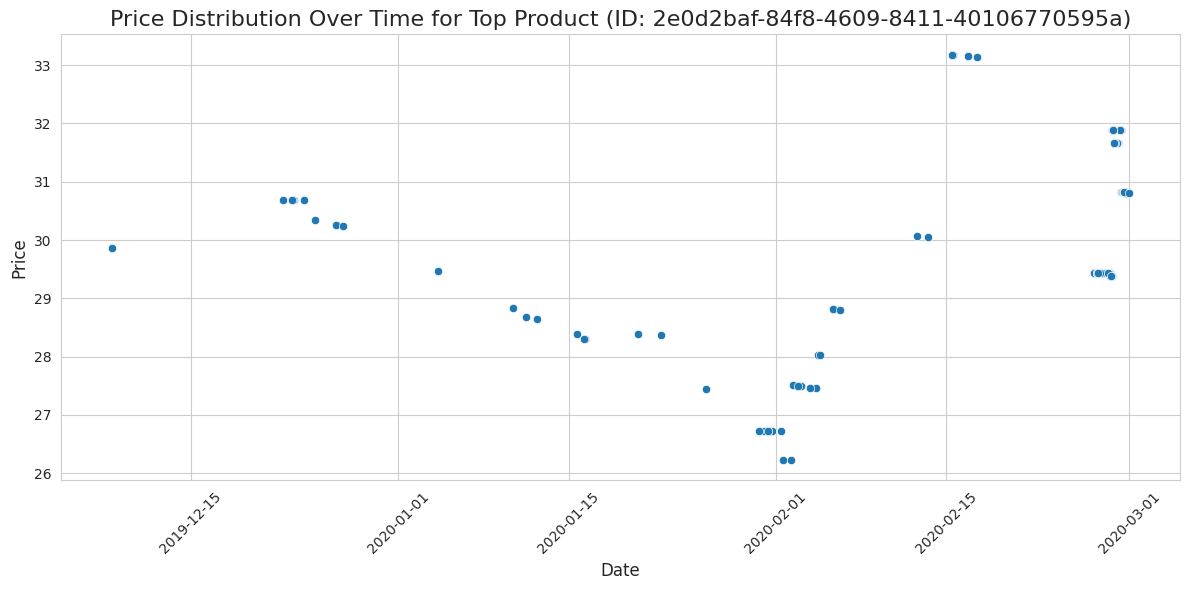

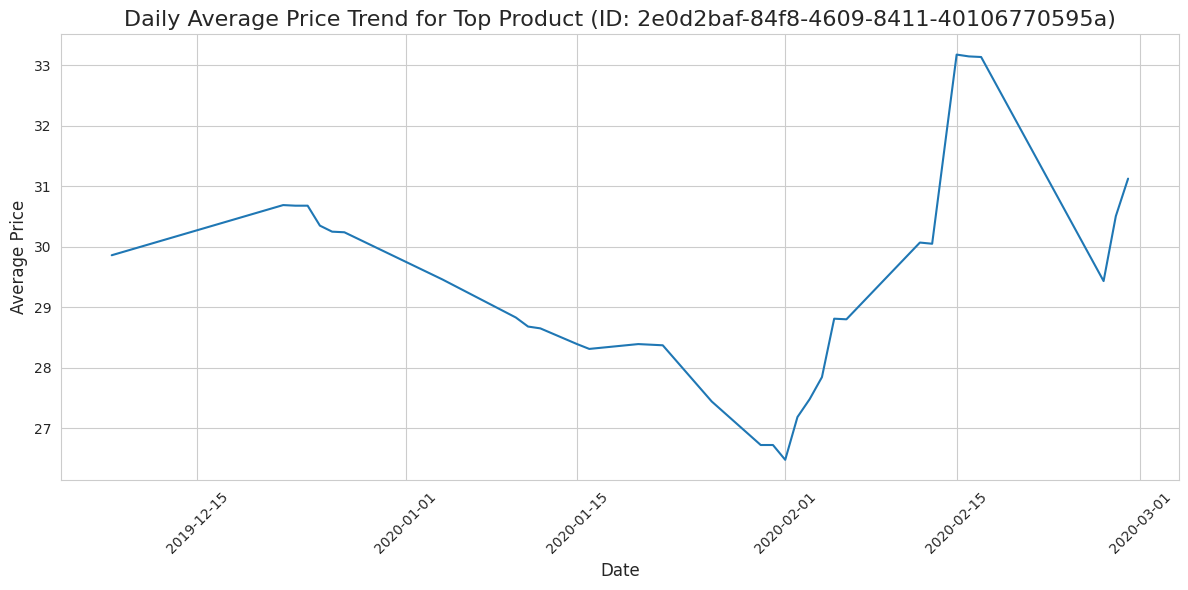

/tmp/ipykernel_920215/3558050054.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_product_purchases['day_of_week'] = top_product_purchases['event_time'].dt.day_name()


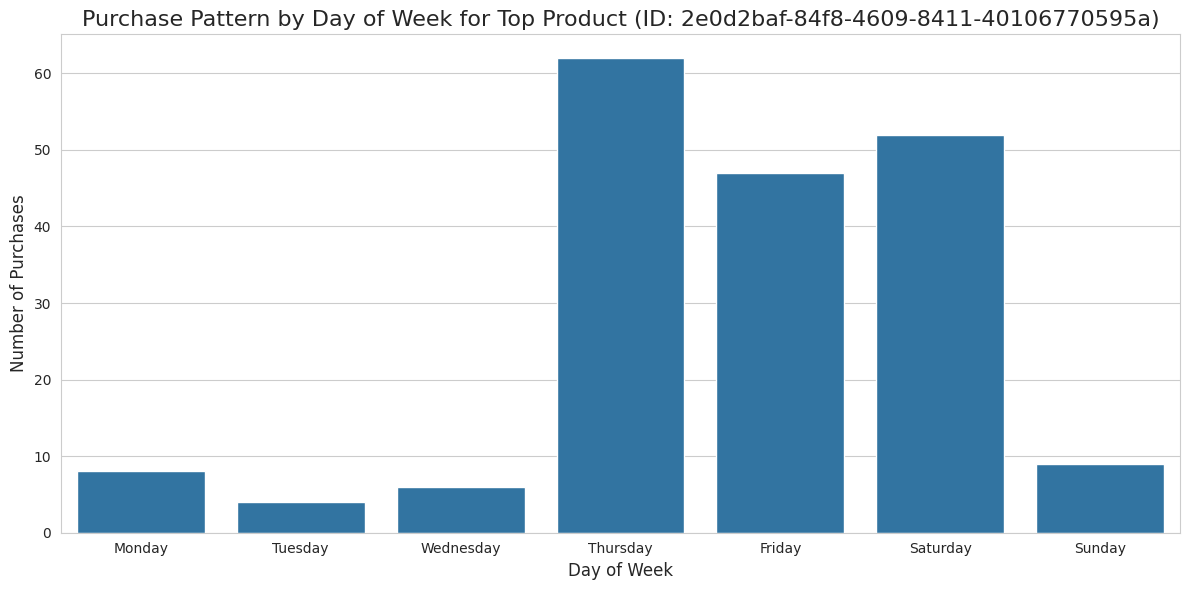

/tmp/ipykernel_920215/3558050054.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_product_purchases['hour'] = top_product_purchases['event_time'].dt.hour


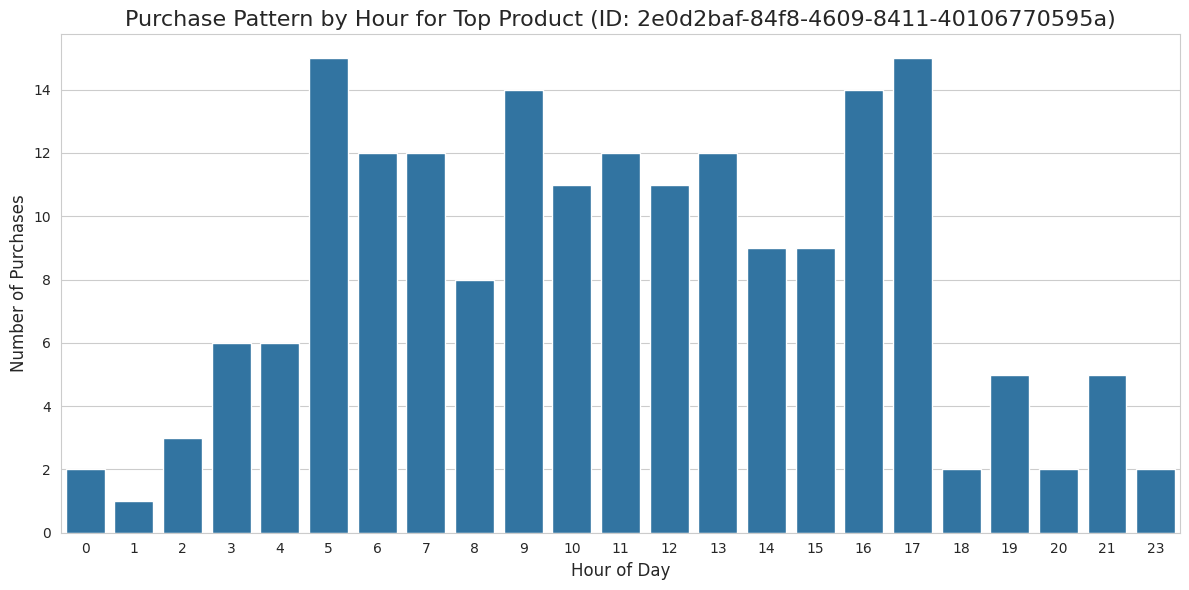

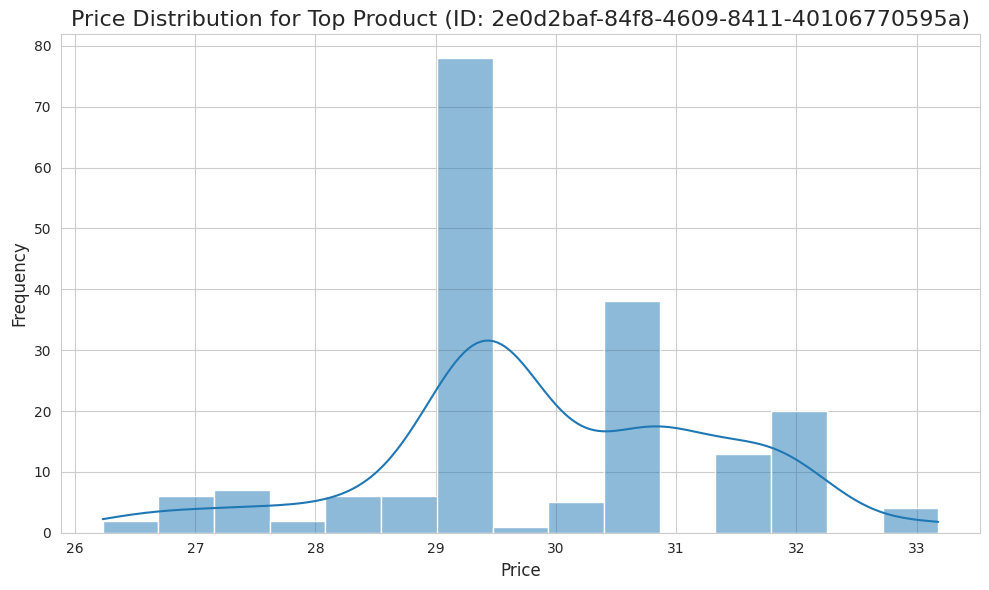

/tmp/ipykernel_920215/3558050054.py:60: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_sales = top_product_purchases.groupby(top_product_purchases['event_time'].dt.to_period('M')).size().reset_index(name='sales')


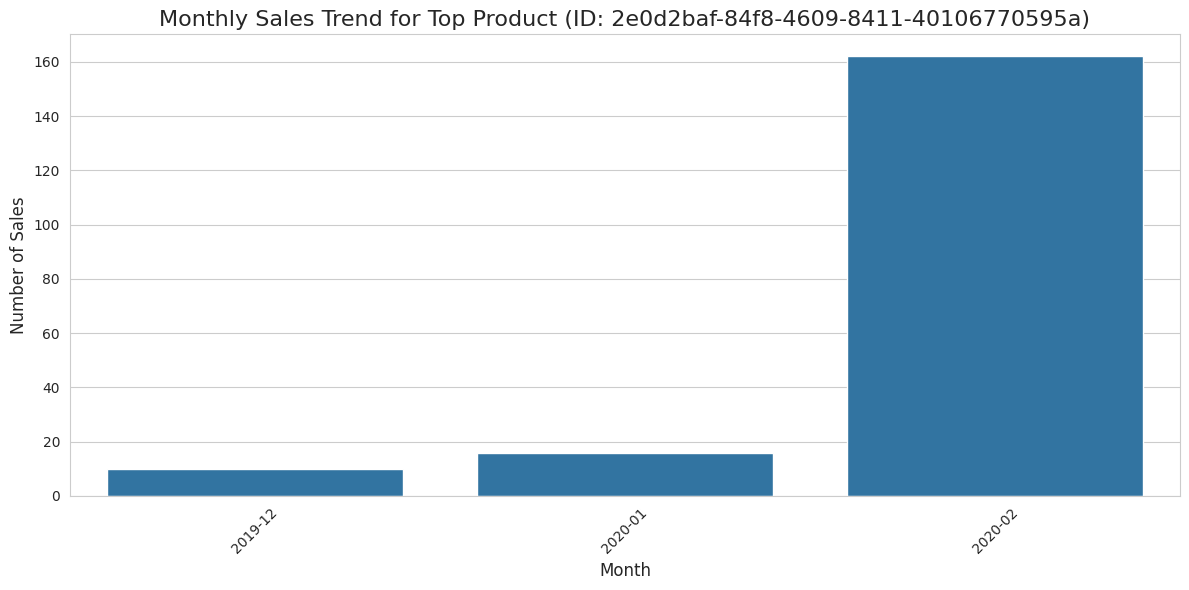

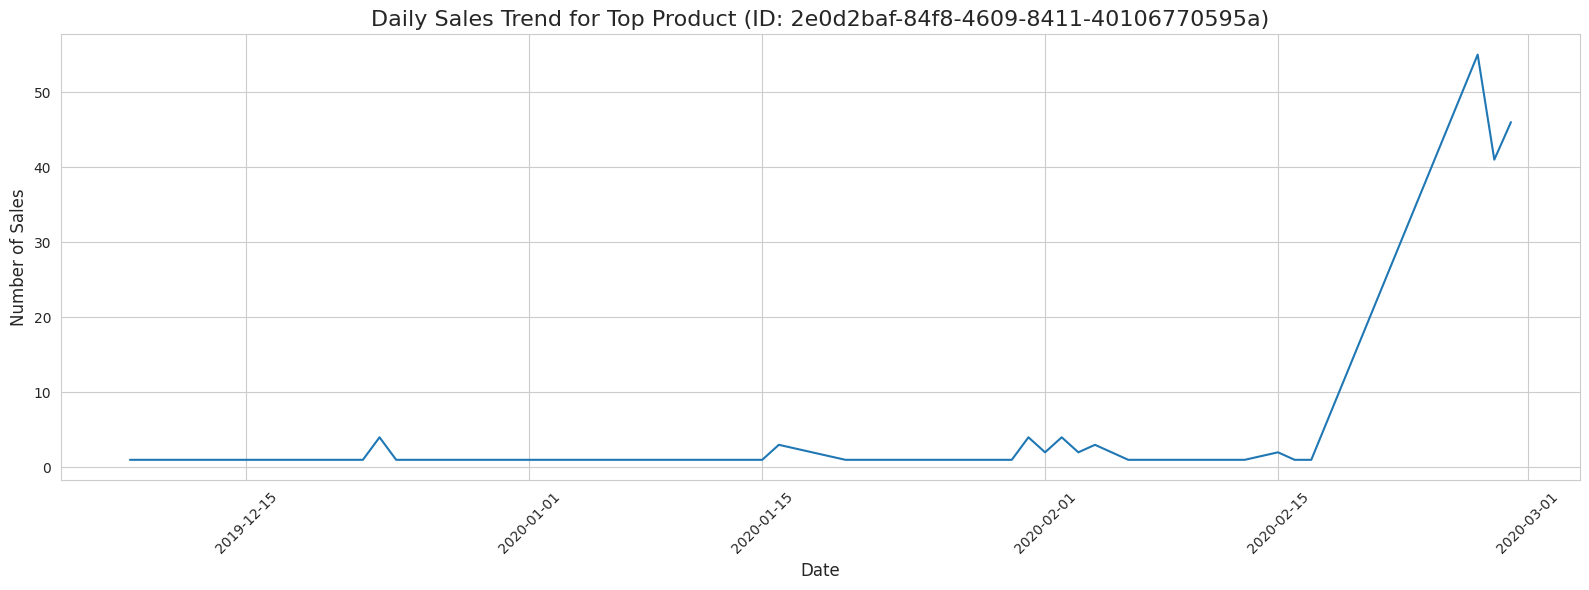

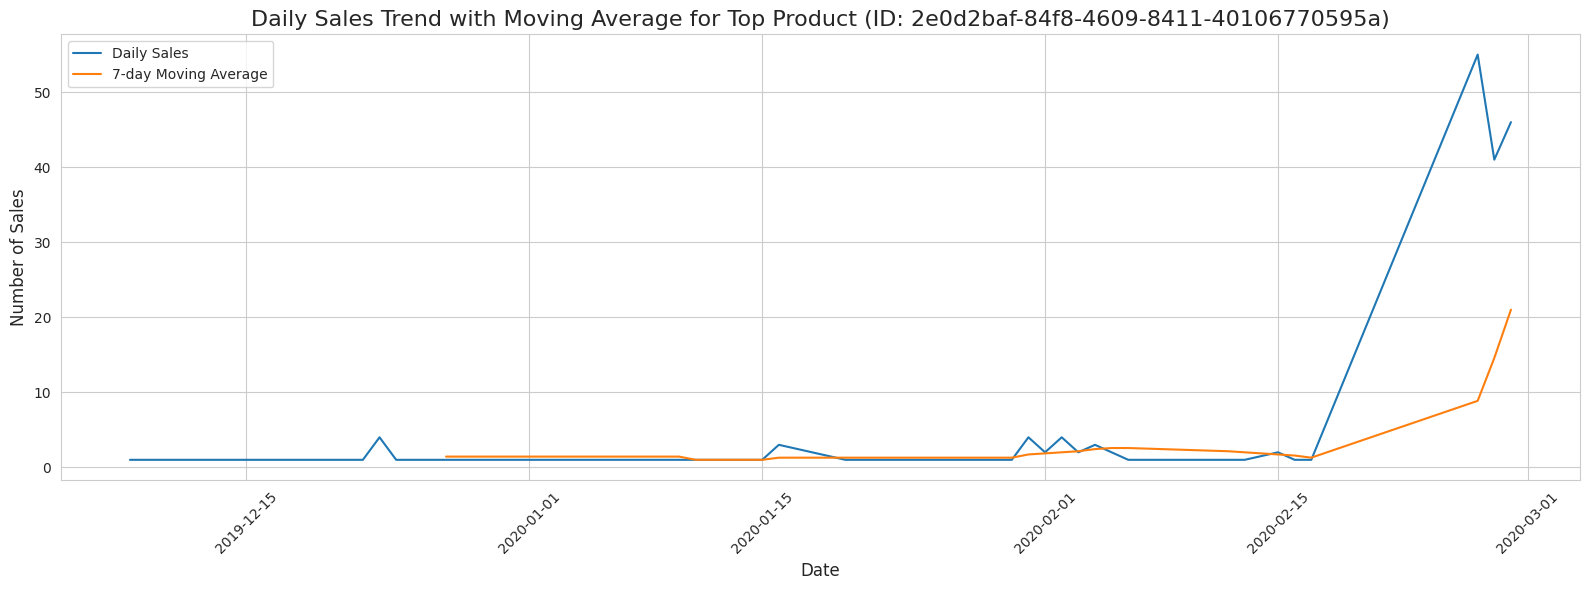

In [11]:
# 가장 많이 팔린 제품 찾기
top_product = purchases['item_id'].value_counts().index[0]
top_product_purchases = purchases[purchases['item_id'] == top_product]

print(f"가장 많이 팔린 제품 ID: {top_product}")
print(f"총 판매량: {len(top_product_purchases)}")

# 1. 시간대별 가격 분포
plt.figure(figsize=(12, 6))
sns.scatterplot(x='event_time', y='price', data=top_product_purchases)
plt.title(f'Price Distribution Over Time for Top Product (ID: {top_product})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. 일별 평균 가격 추세
daily_avg_price = top_product_purchases.groupby(top_product_purchases['event_time'].dt.date)['price'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='event_time', y='price', data=daily_avg_price)
plt.title(f'Daily Average Price Trend for Top Product (ID: {top_product})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. 요일별 구매 패턴
top_product_purchases['day_of_week'] = top_product_purchases['event_time'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.countplot(x='day_of_week', data=top_product_purchases, order=day_order)
plt.title(f'Purchase Pattern by Day of Week for Top Product (ID: {top_product})', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Purchases', fontsize=12)
plt.tight_layout()
plt.show()

# 4. 시간대별 구매 패턴
top_product_purchases['hour'] = top_product_purchases['event_time'].dt.hour
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=top_product_purchases)
plt.title(f'Purchase Pattern by Hour for Top Product (ID: {top_product})', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Purchases', fontsize=12)
plt.tight_layout()
plt.show()

# 5. 가격 범위 분포
plt.figure(figsize=(10, 6))
sns.histplot(top_product_purchases['price'], kde=True)
plt.title(f'Price Distribution for Top Product (ID: {top_product})', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

# 6. 월별 판매량 추이
monthly_sales = top_product_purchases.groupby(top_product_purchases['event_time'].dt.to_period('M')).size().reset_index(name='sales')
monthly_sales['event_time'] = monthly_sales['event_time'].dt.to_timestamp()
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_sales['event_time'].dt.strftime('%Y-%m'), y='sales', data=monthly_sales)
plt.title(f'Monthly Sales Trend for Top Product (ID: {top_product})', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Sales', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. 일별 판매량 추이 (새로 추가된 부분)
daily_sales = top_product_purchases.groupby(top_product_purchases['event_time'].dt.date).size().reset_index(name='sales')
daily_sales['event_time'] = pd.to_datetime(daily_sales['event_time'])

plt.figure(figsize=(16, 6))
sns.lineplot(x='event_time', y='sales', data=daily_sales)
plt.title(f'Daily Sales Trend for Top Product (ID: {top_product})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Sales', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 이동평균을 사용한 일별 판매량 추이 (추가적인 인사이트를 위해)
daily_sales['moving_average'] = daily_sales['sales'].rolling(window=7).mean()

plt.figure(figsize=(16, 6))
sns.lineplot(x='event_time', y='sales', data=daily_sales, label='Daily Sales')
sns.lineplot(x='event_time', y='moving_average', data=daily_sales, label='7-day Moving Average')
plt.title(f'Daily Sales Trend with Moving Average for Top Product (ID: {top_product})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Sales', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Missing Values Analysis:
               Missing Values  Percentage
user_id                     0         0.0
item_id                     0         0.0
user_session                0         0.0
event_time                  0         0.0
category_code               0         0.0
brand                       0         0.0
price                       0         0.0
event_type                  0         0.0


Outliers in price:
Number of outliers: 1146000
Percentage of outliers: 13.72%




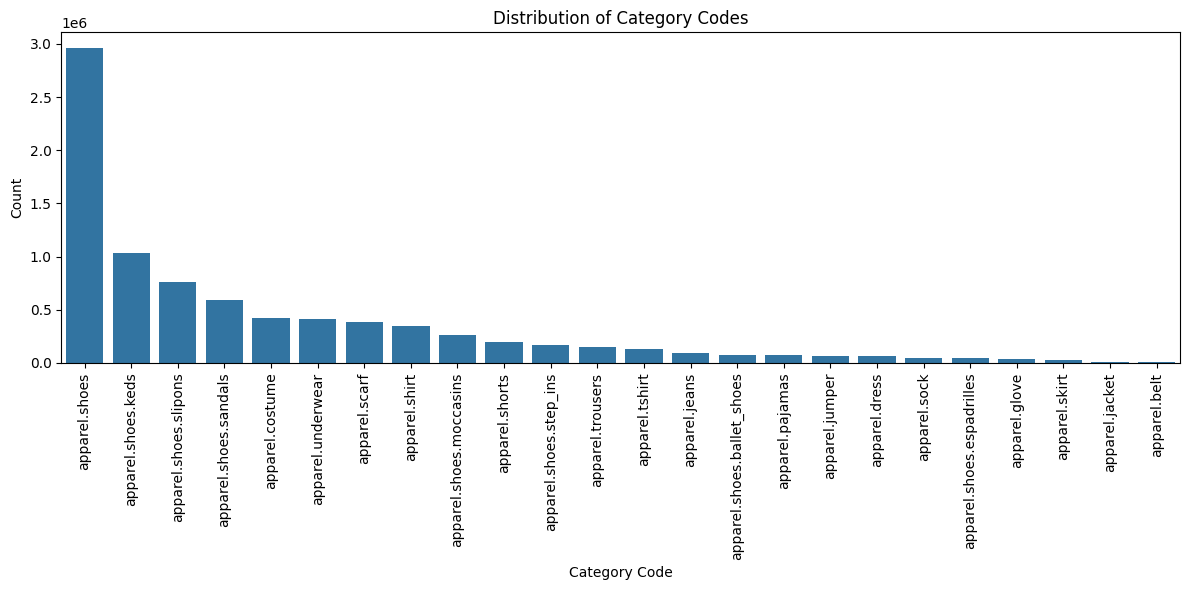

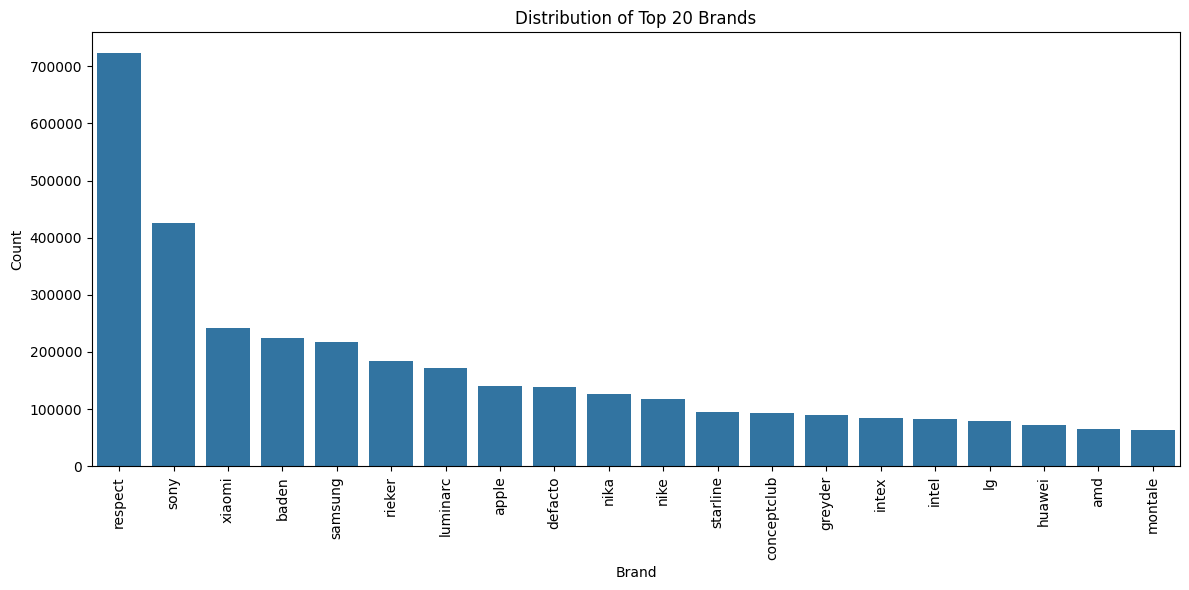

In [8]:
# 결측치 분석
def analyze_missing_values(df):
    missing_values = df.isnull().sum()
    missing_percentages = 100 * df.isnull().sum() / len(df)
    missing_table = pd.concat([missing_values, missing_percentages], axis=1, keys=['Missing Values', 'Percentage'])
    print("Missing Values Analysis:")
    print(missing_table)
    print("\n")

# 이상치 분석 (수치형 변수에 대해)
def analyze_outliers(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        print(f"Outliers in {column}:")
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of outliers: {100 * len(outliers) / len(df):.2f}%")
        print("\n")

# category_code 분포 시각화
def plot_category_distribution(df):
    plt.figure(figsize=(12, 6))
    category_counts = df['category_code'].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.title('Distribution of Category Codes')
    plt.xlabel('Category Code')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# brand 분포 시각화
def plot_brand_distribution(df):
    plt.figure(figsize=(12, 6))
    brand_counts = df['brand'].value_counts().head(20)  # Top 20 brands
    sns.barplot(x=brand_counts.index, y=brand_counts.values)
    plt.title('Distribution of Top 20 Brands')
    plt.xlabel('Brand')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# 메인 실행 코드
if __name__ == "__main__":
    # 결측치 분석
    analyze_missing_values(train_df)

    # 이상치 분석
    analyze_outliers(train_df)

    # category_code 분포 시각화
    plot_category_distribution(train_df)

    # brand 분포 시각화
    plot_brand_distribution(train_df)

/tmp/ipykernel_604209/698260679.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  purchase = user_counts['Purchases'][i]


<Figure size 1500x600 with 0 Axes>

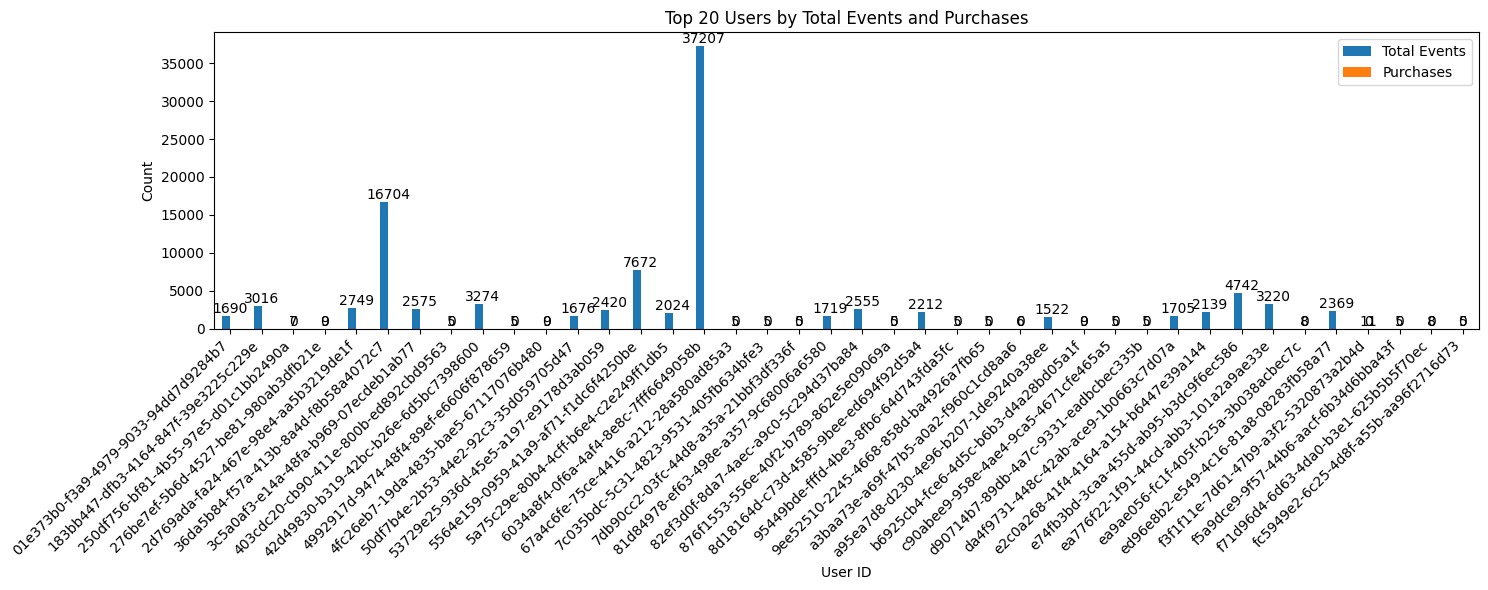

/tmp/ipykernel_604209/698260679.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  purchase = item_counts['Purchases'][i]


<Figure size 1500x600 with 0 Axes>

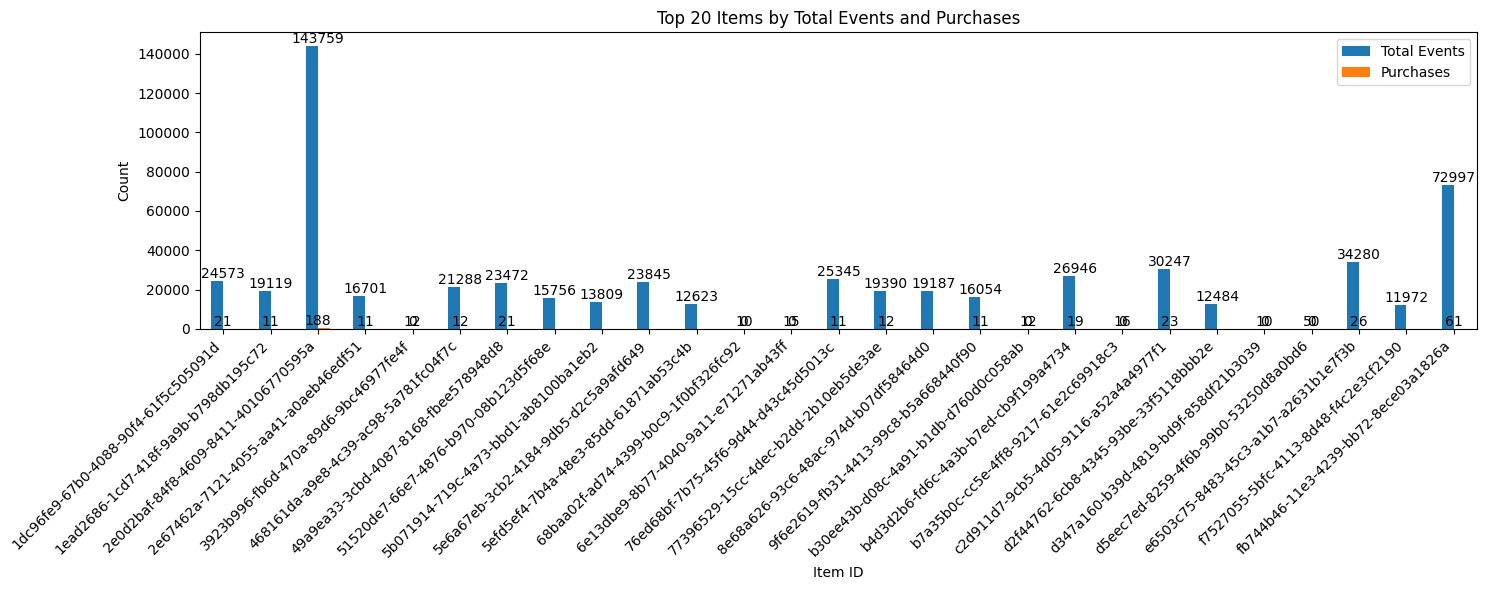

In [7]:
# user_id의 구매 분포와 전체 이벤트 분포 시각화
def plot_user_distribution(df):
    plt.figure(figsize=(15, 6))
    
    # 전체 이벤트 수 계산
    user_event_counts = df['user_id'].value_counts().head(20)
    
    # 구매 이벤트 수 계산
    user_purchase_counts = df[df['event_type'] == 'purchase']['user_id'].value_counts().head(20)
    
    # 두 데이터를 병합
    user_counts = pd.DataFrame({
        'Total Events': user_event_counts,
        'Purchases': user_purchase_counts
    }).fillna(0)
    
    # 그래프 그리기
    ax = user_counts.plot(kind='bar', figsize=(15, 6))
    plt.title('Top 20 Users by Total Events and Purchases')
    plt.xlabel('User ID')
    plt.ylabel('Count')
    plt.legend(['Total Events', 'Purchases'])
    plt.xticks(rotation=45, ha='right')
    
    # 값 표시
    for i, total in enumerate(user_counts['Total Events']):
        plt.text(i, total, f'{total:.0f}', ha='center', va='bottom')
        purchase = user_counts['Purchases'][i]
        if purchase > 0:
            plt.text(i, purchase, f'{purchase:.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# item_id의 분포 시각화
def plot_item_distribution(df):
    plt.figure(figsize=(15, 6))
    
    # 전체 이벤트 수 계산
    item_event_counts = df['item_id'].value_counts().head(20)
    
    # 구매 이벤트 수 계산
    item_purchase_counts = df[df['event_type'] == 'purchase']['item_id'].value_counts().head(20)
    
    # 두 데이터를 병합
    item_counts = pd.DataFrame({
        'Total Events': item_event_counts,
        'Purchases': item_purchase_counts
    }).fillna(0)
    
    # 그래프 그리기
    ax = item_counts.plot(kind='bar', figsize=(15, 6))
    plt.title('Top 20 Items by Total Events and Purchases')
    plt.xlabel('Item ID')
    plt.ylabel('Count')
    plt.legend(['Total Events', 'Purchases'])
    plt.xticks(rotation=45, ha='right')
    
    # 값 표시
    for i, total in enumerate(item_counts['Total Events']):
        plt.text(i, total, f'{total:.0f}', ha='center', va='bottom')
        purchase = item_counts['Purchases'][i]
        if purchase > 0:
            plt.text(i, purchase, f'{purchase:.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# 메인 실행 코드
if __name__ == "__main__":
    # user_id의 구매 분포와 전체 이벤트 분포 시각화
    plot_user_distribution(train_df)

    # item_id의 분포 시각화
    plot_item_distribution(train_df)

In [ ]:
# 날짜 컬럼을 datetime 형식으로 변환
train_df['event_time'] = pd.to_datetime(train_df['event_time'])

# user_id를 유니크한 아이디로 저장
train_df['user_id'] = train_df['user_id'].astype('category')

# cart와 purchase 이벤트는 그대로 유지
cart_purchase = train_df[train_df['event_type'].isin(['cart', 'purchase'])]

# view 이벤트만 있는 사용자 처리
view_only = train_df[train_df['event_type'] == 'view']
last_views = view_only.groupby('user_id').apply(lambda x: x.loc[x['event_time'].idxmax()])
last_views = last_views.reset_index(drop=True)

# 데이터 합치기
processed_df = pd.concat([cart_purchase, last_views])

# 사용자별 가장 많이 본 카테고리 찾기
user_top_category = processed_df.groupby('user_id')['category_code'].agg(lambda x: x.value_counts().index[0]).reset_index()
user_top_category.columns = ['user_id', 'top_category']

# 결과 데이터프레임 생성
result_df = processed_df.merge(user_top_category, on='user_id', how='left')

# EDA 시작
print("데이터 샘플:")
print(result_df.head())

print("\n기본 통계:")
print(result_df.describe())

print("\n이벤트 타입별 개수:")
print(result_df['event_type'].value_counts())

print("\n상위 10개 카테고리:")
print(result_df['category_code'].value_counts().head(10))

# 시각화: 이벤트 타입별 분포
plt.figure(figsize=(10, 6))
sns.countplot(x='event_type', data=result_df)
plt.title('Distribution of Event Types')
plt.show()

# 시각화: 상위 10개 카테고리 분포
plt.figure(figsize=(12, 6))
top_categories = result_df['category_code'].value_counts().head(10)
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.title('Top 10 Categories')
plt.xticks(rotation=45)
plt.show()

# 시각화: 사용자별 가장 많이 본 카테고리 분포
plt.figure(figsize=(12, 6))
top_user_categories = result_df['top_category'].value_counts().head(10)
sns.barplot(x=top_user_categories.index, y=top_user_categories.values)
plt.title('Top 10 User Favorite Categories')
plt.xticks(rotation=45)
plt.show()

# 시각화: 시간대별 이벤트 발생 횟수
result_df['hour'] = result_df['event_time'].dt.hour
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=result_df, hue='event_type')
plt.title('Event Distribution by Hour')
plt.show()

print("\n브랜드별 평균 가격:")
print(result_df.groupby('brand')['price'].mean().sort_values(ascending=False).head(10))

## submission 검증

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def validate_submission(output_file, sample_submission_file):
    # CSV 파일 읽기
    print("Reading CSV files...")
    output_df = pd.read_csv(output_file)
    sample_df = pd.read_csv(sample_submission_file)

    # 사용자별 추천 아이템 수 계산
    print("Calculating recommendations per user...")
    output_counts = output_df.groupby('user_id').size()

    # sample_submission의 모든 사용자가 output에 있는지 확인
    print("Checking for missing users...")
    missing_users = set(sample_df['user_id']) - set(output_df['user_id'])
    
    print(f"Total users in sample_submission: {sample_df['user_id'].nunique()}")
    print(f"Total users in output: {output_df['user_id'].nunique()}")
    print(f"Missing users in output: {len(missing_users)}")

    if len(missing_users) > 0:
        print("First 10 missing users:", list(missing_users)[:10])

    # 각 사용자별로 10개의 추천이 있는지 확인
    print("Checking for invalid number of recommendations...")
    invalid_users = output_counts[output_counts != 10]
    
    print(f"\nUsers with invalid number of recommendations: {len(invalid_users)}")
    if len(invalid_users) > 0:
        print("Sample of invalid users:")
        print(invalid_users.head())

    # 중복 추천 확인
    print("Checking for duplicate recommendations...")
    users_with_duplicates = []
    for user_id, group in tqdm(output_df.groupby('user_id'), desc="Checking duplicates"):
        if group['item_id'].duplicated().any():
            users_with_duplicates.append(user_id)

    print(f"\nUsers with duplicate recommendations: {len(users_with_duplicates)}")
    if len(users_with_duplicates) > 0:
        print("Sample of users with duplicates:")
        print(users_with_duplicates[:10])

    # 전체 검증 결과
    is_valid = (len(missing_users) == 0) and (len(invalid_users) == 0) and (len(users_with_duplicates) == 0)
    
    print(f"\nOverall validation result: {'PASSED' if is_valid else 'FAILED'}")
    
    return is_valid

In [2]:
output_file = './output/output.csv'
sample_submission_file = './data/sample_submission.csv'

In [3]:
is_valid = validate_submission(output_file, sample_submission_file)

Reading CSV files...
Calculating recommendations per user...
Checking for missing users...
Total users in sample_submission: 638257
Total users in output: 638257
Missing users in output: 0
Checking for invalid number of recommendations...

Users with invalid number of recommendations: 0
Checking for duplicate recommendations...


Checking duplicates: 100%|██████████| 638257/638257 [00:46<00:00, 13693.76it/s]



Users with duplicate recommendations: 0

Overall validation result: PASSED
